***Sentiment Classifier***

<ul>
    <li>text from 1.6 million tweets with sentiment labels 
    <li>labels are 0 for negative and 4 for positive
    <li>Uses Sentiment140 dataset from http://help.sentiment140.com/home


In [1]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

***global variables***

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.


- `MAXLEN`: Maximum length of all sequences. Defaults to 16.


- `TRUNCATING`: Truncating strategy (truncate either before or after each sequence.). Defaults to 'post'.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to \"\\<OOV>\".
    
    
- `MAX_EXAMPLES`: Max number of examples to use. Defaults to 160000 (10% of the original number of examples)
    
    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.9
    

In [2]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

***Load Data from Twitter***

CSV file with columns:

- target: the polarity of the tweet (0 = negative, 4 = positive)

- ids: The id of the tweet

- date: the date of the tweet

- flag: The query. If there is no query, then this value is NO_QUERY.

- user: the user that tweeted

- text: the text of the tweet

In [3]:
SENTIMENT_CSV = "D:/tmp/tweet_sentiment/training_cleaned.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    for i in range(0,3):
     print("record {}: {}".format(i,csvfile.readline()))

record 0: "0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","

record 1: TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

record 2: "0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



***Parse data***


In [4]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    
    sentences = []
    labels = []

    with open(filename, 'r',encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            labels.append(row[0])
            sentences.append(row[5])
            
    labels = [ 1 if label =="4" else 0 for label in labels]       # map from Twitter's 0-4 to 0-1.              
        
    return sentences, labels

In [7]:
sentences, labels = parse_data_from_file(SENTIMENT_CSV)
print(f"{len(sentences)} .csv records\n")

for i in [0,1,-2,-1]:
    print("sentence {}: {}\nlabel {} = {}\n".format(i,sentences[i], i,labels[i]))

1600000 .csv records

sentence 0: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
label 0 = 0

sentence 1: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
label 1 = 0

sentence -2: Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur 
label -2 = 1

sentence -1: happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H 
label -1 = 1



***Take a random 10% of the records***

In [8]:
# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



***Training - Validation Split***

In [9]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """    

    # Compute the number of sentences that will be used for training
    train_size = int(len(labels)*training_split )

    # Slice the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [10]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"{len(train_sentences)} sentences and {len(train_labels)} labels for training")
print(f"{len(val_sentences)} sentences and {len(val_labels)} labels for validation")


144000 sentences and 144000 labels for training
16000 sentences and 16000 labels for validation


***Create Tokenizer***

In [11]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    
    # Instantiate the Tokenizer class, passing in the correct value for oov_token
    tokenizer = Tokenizer(oov_token=OOV_TOKEN)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [12]:
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary is {VOCAB_SIZE} words")
print("<OOV> token is included in vocabulary\n" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
for word in ['i', 'am', 'sam']: print(f"nindex of word {word} is {word_index[word]}")

Vocabulary is 128898 words
<OOV> token is included in vocabulary

nindex of word i is 2
nindex of word am is 66
nindex of word sam is 1797


***Tokenize, pad,  and truncate***


In [18]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """        
    # Convert sentences to sequences
    sequences=tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    return pad_trunc_sequences

In [43]:
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Training sequencess: {train_pad_trunc_seq.shape}")
print(f"Validation sequences: {val_pad_trunc_seq.shape}")
print('Labels:',type(train_labels),np.shape(train_labels))
print(train_pad_trunc_seq[1])

Training sequencess: (144000, 16)
Validation sequences: (16000, 16)
Labels: <class 'numpy.ndarray'> (144000,)
[   6  228 1423 3270  605 9418 3691 3691   78  314  369    2   95    3
  141    0]


***Turn lables into array***

In [15]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
print('Labels:',type(train_labels),np.shape(train_labels))

Labels: <class 'numpy.ndarray'> (144000,)


***Load 100d GloVe embedding word vectors***

[GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [16]:
# Define path to file containing the embeddings
GLOVE_FILE = 'D:/data/NLP/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE ,encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

***Test***

In [17]:
test_word = 'dog'
test_vector = GLOVE_EMBEDDINGS[test_word]
print(f"{test_word} vector:\n\n{test_vector}")

dog vector:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.30569    0.31748    0.021404
  0.11837  

In [19]:
print(f" {type(test_vector)},{test_vector.shape}")

 <class 'numpy.ndarray'>,(100,)


## Represent the words in your vocabulary using the embeddings

Save the vector representation of each word in the vocabulary in a numpy array.

A couple of things to notice:
- If a word in your vocabulary is not present in `GLOVE_EMBEDDINGS` the representation for that word is left as a column of zeros.
- `word_index` starts counting at 1, because of this you will need to add an extra column at the left-most side of the `EMBEDDINGS_MATRIX` array. This is the reason why you add 1 to `VOCAB_SIZE` in the cell below:

In [31]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector
        
for word in ['i','am','sam']:
    print('word: ',word,'\nindex',word_index[word], '\nEmbedding:\n',EMBEDDINGS_MATRIX[word_index[word]],'\n')

word:  i 
index 2 
Embedding:
 [-0.046539    0.61966002  0.56647003 -0.46584001 -1.18900001  0.44599
  0.066035    0.31909999  0.14679    -0.22119001  0.79238999  0.29905
  0.16073     0.025324    0.18678001 -0.31000999 -0.28108001  0.60514998
 -1.0654      0.52476001  0.064152    1.03579998 -0.40779001 -0.38011
  0.30801001  0.59964001 -0.26991001 -0.76034999  0.94221997 -0.46919
 -0.18278     0.90652001  0.79671001  0.24824999  0.25713     0.6232
 -0.44768     0.65357     0.76902002 -0.51229    -0.44332999 -0.21867
  0.38370001 -1.14830005 -0.94397998 -0.15062     0.30012    -0.57805997
  0.20175    -1.65910006 -0.079195    0.026423    0.22051001  0.99713999
 -0.57538998 -2.72659993  0.31448001  0.70521998  1.43809998  0.99125999
  0.13976     1.34739995 -1.1753      0.0039503   1.02980006  0.064637
  0.90886998  0.82871997 -0.47003001 -0.10575     0.5916     -0.42210001
  0.57331002 -0.54114002  0.10768     0.39783999 -0.048744    0.064596
 -0.61436999 -0.28600001  0.50669998 -0.497

***Create  CNN model***

In [32]:

def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model designed to avoid overfitting
    
    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    
    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    # I wanted RNN to work better, but CONV1D gives best results
    model = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False), 
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv1D(128,5,activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

***Train the model***

In [33]:
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
4500/4500 [==============================] - 15s 3ms/step - loss: 0.5817 - accuracy: 0.6897 - val_loss: 0.5361 - val_accuracy: 0.7302
Epoch 2/20
4500/4500 [==============================] - 11s 3ms/step - loss: 0.5400 - accuracy: 0.7255 - val_loss: 0.5223 - val_accuracy: 0.7389
Epoch 3/20
4500/4500 [==============================] - 12s 3ms/step - loss: 0.5230 - accuracy: 0.7355 - val_loss: 0.5109 - val_accuracy: 0.7447
Epoch 4/20
4500/4500 [==============================] - 11s 3ms/step - loss: 0.5123 - accuracy: 0.7442 - val_loss: 0.5062 - val_accuracy: 0.7504
Epoch 5/20
4500/4500 [==============================] - 11s 3ms/step - loss: 0.5052 - accuracy: 0.7488 - val_loss: 0.5011 - val_accuracy: 0.7549
Epoch 6/20
4500/4500 [==============================] - 11s 3ms/step - loss: 0.4984 - accuracy: 0.7541 - val_loss: 0.4973 - val_accuracy: 0.7585
Epoch 7/20
4500/4500 [==============================] - 12s 3ms/step - loss: 0.4928 - accuracy: 0.7580 - val_loss: 0.4974 - val_ac

***Targets***
<table><tr><td><img src='images/valid-1.png'></td><td><img src='images/valid-2.jpg'></td><td><img src='images/valid-3.jpg'></td></tr></table>
 
***Overfitting***

<img src='images/invalid-1.jpg' width=315 height=265 align="left"/>

***Training Analysis***

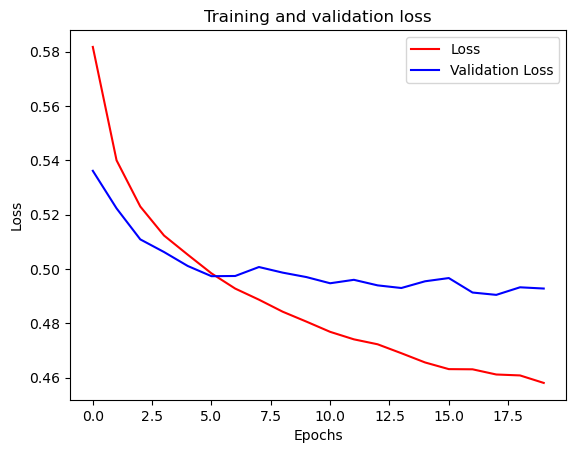

In [34]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

If you wish so, you can also check the training and validation accuracies of your model:

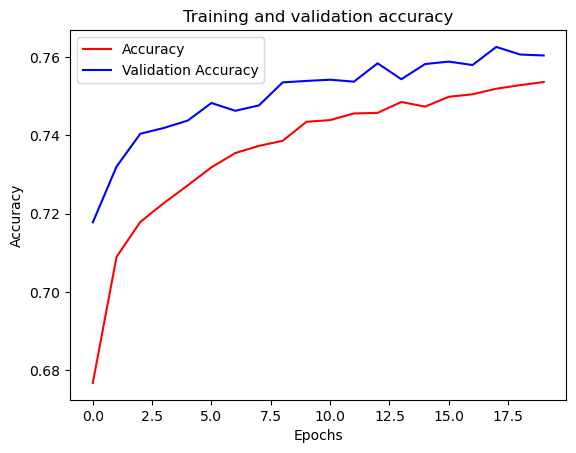

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [35]:
# Test the slope of your val_loss curve
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00147


***Download History File***

In [36]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

***Test predictions***

In [152]:
test1='The world is happy and beautiful and peaceful and kind'
test2='What a tragic fail it is, full of misery and incompetence'

testsent=[test1,test2]
sequences = seq_pad_and_trunc(testsent, tokenizer, PADDING, TRUNCATING, MAXLEN)
#print('First sequence: \n',sequences[0],'\n')

temp=sequences[1]
temp=temp.reshape(1,16)

for i in range(0,2):
    sequence=sequences[i].reshape(1,16)
    print('"',testsent[i],'"  result is ',model.predict(sequence),'\n')

" The world is happy and beautiful and peaceful and kind "  result is  [[0.98553026]] 

" What a tragic fail it is, full of misery and incompetence "  result is  [[0.1621104]] 

